## Canada Crop Analysis - wheat production in the NPL region

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import urllib
import sklearn

import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

## Preprocessing

In [256]:
climate_data = pd.read_csv("cleaned_data_NPL.csv")

In [257]:
climate_data_NPL = climate_data[climate_data['region']=='NPL']
climate_data_NPL.head()

,Unnamed: 0,combined,date,dry,hightemp,lowtemp,rain,region,sealevel,wind
4949,4949,0.18,1961/1/1,-0.31,-0.18,0.04,-0.18,NPL,1.23,0.53
4950,4950,0.19,1961/2/1,-0.28,-0.15,0.00,-0.15,NPL,1.21,0.53
4951,4951,0.19,1961/3/1,-0.26,-0.14,-0.03,-0.19,NPL,1.20,0.51
4952,4952,0.20,1961/4/1,-0.24,-0.14,-0.03,-0.17,NPL,1.20,0.54
4953,4953,0.21,1961/5/1,-0.22,-0.13,-0.03,-0.17,NPL,1.20,0.56


In [258]:
climate_data_NPL['year'] = pd.DatetimeIndex(climate_data_NPL['date']).year
climate_data_NPL.head()

/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,combined,date,dry,hightemp,lowtemp,rain,region,sealevel,wind,year
4949,4949,0.18,1961/1/1,-0.31,-0.18,0.04,-0.18,NPL,1.23,0.53,1961
4950,4950,0.19,1961/2/1,-0.28,-0.15,0.00,-0.15,NPL,1.21,0.53,1961
4951,4951,0.19,1961/3/1,-0.26,-0.14,-0.03,-0.19,NPL,1.20,0.51,1961
4952,4952,0.20,1961/4/1,-0.24,-0.14,-0.03,-0.17,NPL,1.20,0.54,1961
4953,4953,0.21,1961/5/1,-0.22,-0.13,-0.03,-0.17,NPL,1.20,0.56,1961


In [259]:
# Group by year, applying average
climate_by_year = climate_data_NPL.groupby(['year'], as_index=False).mean()
climate_by_year.head()

,year,Unnamed: 0,combined,dry,hightemp,lowtemp,rain,sealevel,wind
0,1961,4954.5,0.211667,-0.188333,-0.095000,-0.028333,-0.211667,1.201667,0.535833
1,1962,4966.5,0.241667,0.006667,-0.080833,-0.004167,-0.154167,1.133333,0.537500
2,1963,4978.5,0.235000,0.049167,-0.043333,-0.030833,-0.115833,1.098333,0.396667
3,1964,4990.5,0.205833,0.030000,0.071667,-0.128333,-0.130833,1.044167,0.085000
4,1965,5002.5,0.155833,0.046667,0.023333,-0.085000,-0.078333,1.002500,-0.145833


In [260]:
NPL_crops_0 = pd.read_excel("NPL_Crops.xlsx", sheet_name ='NPL1961-2020')
NPL_crops = NPL_crops_0[NPL_crops_0['year'] > 1960]
NPL_crops.head()

,year,NPL Wheat production,Alberta-Wheat(Production),Saskatchewan-Wheat(Production),Manitoba-Wheat(Production)
53,1961,7077.0,2422.0,3729.0,926.0
54,1962,14860.0,3048.0,9635.0,2177.0
55,1963,19132.0,4055.0,13417.0,1660.0
56,1964,15730.0,3946.0,9471.0,2313.0
57,1965,17200.0,4164.0,10886.0,2150.0


In [261]:
climate_by_year.set_index('year',inplace=True)
NPL_crops.set_index('year',inplace=True)
df = pd.concat([climate_by_year,NPL_crops],axis=1,sort=False).reset_index()
df.rename(columns = {'index':'year'})

,year,Unnamed: 0,combined,dry,hightemp,lowtemp,rain,sealevel,wind,NPL Wheat production,Alberta-Wheat(Production),Saskatchewan-Wheat(Production),Manitoba-Wheat(Production)
0,1961,4954.5,0.211667,-0.188333,-0.095000,-2.833333e-02,-0.211667,1.201667,0.535833,7077.0,2422.0,3729.0,926.0
1,1962,4966.5,0.241667,0.006667,-0.080833,-4.166667e-03,-0.154167,1.133333,0.537500,14860.0,3048.0,9635.0,2177.0
2,1963,4978.5,0.235000,0.049167,-0.043333,-3.083333e-02,-0.115833,1.098333,0.396667,19132.0,4055.0,13417.0,1660.0
3,1964,4990.5,0.205833,0.030000,0.071667,-1.283333e-01,-0.130833,1.044167,0.085000,15730.0,3946.0,9471.0,2313.0
4,1965,5002.5,0.155833,0.046667,0.023333,-8.500000e-02,-0.078333,1.002500,-0.145833,17200.0,4164.0,10886.0,2150.0
5,1966,5014.5,0.087500,0.107500,-0.097500,6.250000e-02,0.036667,0.961667,-0.423333,21963.0,5198.0,14615.0,2150.0
6,1967,5026.5,0.050000,0.094167,-0.131667,8.750000e-02,0.020000,0.942500,-0.545000,15621.0,3946.0,9226.0,2449.0
7,1968,5038.5,0.062500,0.251667,-0.160833,1.566667e-01,-0.022500,0.967500,-0.500833,17120.0,4518.0,10125.0,2477.0
8,1969,5050.5,0.018333,0.289167,-0.320833,3.075000e-01,0.048333,0.947500,-0.538333,17745.0,3810.0,12193.0,1742.0
9,1970,5062.5,0.041667,0.209167,-0.263333,2.308333e-01,0.043333,0.932500,-0.439167,8504.0,1959.0,5715.0,830.0


In [262]:
df.drop(['Unnamed: 0','Alberta-Wheat(Production)','Saskatchewan-Wheat(Production)','Manitoba-Wheat(Production)'], axis=1, inplace=True)
df.head()

,year,combined,dry,hightemp,lowtemp,rain,sealevel,wind,NPL Wheat production
0,1961,0.211667,-0.188333,-0.095000,-0.028333,-0.211667,1.201667,0.535833,7077.0
1,1962,0.241667,0.006667,-0.080833,-0.004167,-0.154167,1.133333,0.537500,14860.0
2,1963,0.235000,0.049167,-0.043333,-0.030833,-0.115833,1.098333,0.396667,19132.0
3,1964,0.205833,0.030000,0.071667,-0.128333,-0.130833,1.044167,0.085000,15730.0
4,1965,0.155833,0.046667,0.023333,-0.085000,-0.078333,1.002500,-0.145833,17200.0


In [281]:
#df['year'] = df['year'].astype(float)
#df['combined'] = df['combined'].astype(float)
#df['dry'] = df['dry'].astype(float)
#df['hightemp'] = df['hightemp'].astype(float)
#df['lowtemp'] = df['lowtemp'].astype(float)
#df['rain'] = df['rain'].astype(float)
#df['sealevel'] = df['sealevel'].astype(float)
#df['wind'] = df['wind'].astype(float)
#df['NPL Wheat production'] = df['NPL Wheat production'].astype(float)
df.to_csv('NPLCropCleaned.txt',header=False,sep='\t')

In [282]:
# Preprocessing and scale
X_prime = df[['combined','dry','hightemp','lowtemp','rain','sealevel', 'wind']].values
y = df.iloc[:,-1].values
X = preprocessing.scale(X_prime)

## Train test split based on time series

In [283]:
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=10)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=3)
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18 19 20 21 22 23 24 25 26 27 28 29 30]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] TEST: [31 32 33 34 35 36 37 38 39 40 41 42 43 44]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] TEST: [45 46 47 48 49 50 51 52 53 54 55 56 57 58]


/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


## Standard Regression

In [284]:
from numpy import *

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) - 1 #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [285]:
dataMat, labelMat = loadDataSet("NPLCropCleaned.txt")

In [286]:
dataMat[0:5], labelMat[0:5]

([[0.0,
   1961.0,
   0.21166666666666667,
   -0.18833333333333332,
   -0.09500000000000001,
   -0.028333333333333332,
   -0.21166666666666667,
   1.2016666666666664,
   0.5358333333333335],
  [1.0,
   1962.0,
   0.2416666666666667,
   0.006666666666666667,
   -0.08083333333333333,
   -0.004166666666666667,
   -0.15416666666666665,
   1.1333333333333333,
   0.5375],
  [2.0,
   1963.0,
   0.23500000000000001,
   0.049166666666666664,
   -0.04333333333333333,
   -0.030833333333333338,
   -0.1158333333333333,
   1.0983333333333334,
   0.39666666666666667],
  [3.0,
   1964.0,
   0.20583333333333334,
   0.03000000000000001,
   0.07166666666666667,
   -0.12833333333333333,
   -0.13083333333333336,
   1.0441666666666665,
   0.085],
  [4.0,
   1965.0,
   0.1558333333333333,
   0.04666666666666667,
   0.023333333333333334,
   -0.085,
   -0.07833333333333334,
   1.0025000000000002,
   -0.14583333333333334]],
 [7077.0, 14860.0, 19132.0, 15730.0, 17200.0])

In [287]:
def standRegres(xArr,yArr):
    xMat = mat(xArr); yMat = mat(yArr).T
    print("xMat:", xMat[0:5])
    print("yMat:", yMat[0:5])
    
    xTx = xMat.T*xMat #this is X^T X 
    print("xTx:", xTx)
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse") #p (number of feat) > n? if so, abort mission
        return
    betas = xTx.I * (xMat.T*yMat) #This is the least squares result
    return betas

In [288]:
ws = standRegres(dataMat, labelMat)

xMat: [[ 0.00000000e+00  1.96100000e+03  2.11666667e-01 -1.88333333e-01
  -9.50000000e-02 -2.83333333e-02 -2.11666667e-01  1.20166667e+00
   5.35833333e-01]
 [ 1.00000000e+00  1.96200000e+03  2.41666667e-01  6.66666667e-03
  -8.08333333e-02 -4.16666667e-03 -1.54166667e-01  1.13333333e+00
   5.37500000e-01]
 [ 2.00000000e+00  1.96300000e+03  2.35000000e-01  4.91666667e-02
  -4.33333333e-02 -3.08333333e-02 -1.15833333e-01  1.09833333e+00
   3.96666667e-01]
 [ 3.00000000e+00  1.96400000e+03  2.05833333e-01  3.00000000e-02
   7.16666667e-02 -1.28333333e-01 -1.30833333e-01  1.04416667e+00
   8.50000000e-02]
 [ 4.00000000e+00  1.96500000e+03  1.55833333e-01  4.66666667e-02
   2.33333333e-02 -8.50000000e-02 -7.83333333e-02  1.00250000e+00
  -1.45833333e-01]]
yMat: [[ 7077.]
 [14860.]
 [19132.]
 [15730.]
 [17200.]]
xTx: [[ 6.67290000e+04  3.42200000e+06 -2.64349091e+02 -3.45633939e+02
   2.74924318e+02 -3.14709773e+02  1.45183106e+02 -2.42582439e+03
   4.51696818e+02]
 [ 3.42200000e+06  2.3366

In [289]:
ws #intercept+coefficient

matrix([[-4.67784482e+02],
        [ 1.41161783e+01],
        [-6.38790257e+04],
        [ 1.22929443e+04],
        [ 2.11561649e+04],
        [-6.73902075e+03],
        [ 2.80985887e+04],
        [ 2.03173081e+03],
        [ 9.29318444e+03]])

In [290]:
xMat = mat(dataMat); yMat = mat(labelMat)
yHat = xMat*ws

In [291]:
yHat[0:5]

matrix([[11500.22378312],
        [13156.48407176],
        [14321.40132305],
        [15157.36325551],
        [16033.30015601]])

In [292]:
labelMat[0:5]

[7077.0, 14860.0, 19132.0, 15730.0, 17200.0]

Text(0, 0.5, 'Production(000 t)')

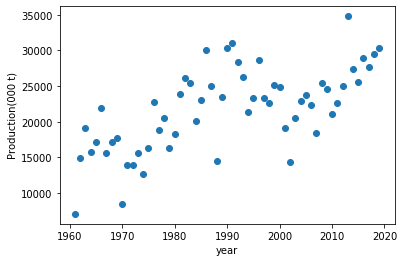

In [293]:
# xMat yMat
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0])
plt.xlabel('year')
plt.ylabel('Production(000 t)')

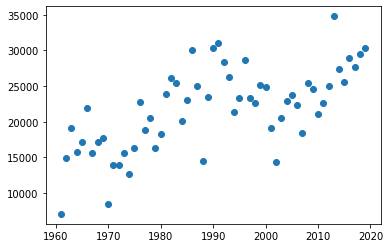

In [294]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0])

In [295]:
xCopy=xMat.copy()
xCopy.sort(0)
yHat=xCopy*ws
ax.plot(xCopy[:,1],yHat, color = "red")
plt.show()

In [296]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression(fit_intercept=False).fit(array(dataMat),array(labelMat))
print(linReg.coef_)

[-4.67784482e+02  1.41161783e+01 -6.38790257e+04  1.22929443e+04
  2.11561649e+04 -6.73902075e+03  2.80985887e+04  2.03173081e+03
  9.29318444e+03]


In [297]:
print(linReg.score(array(dataMat),array(labelMat))) #R^2

0.5853969464008362


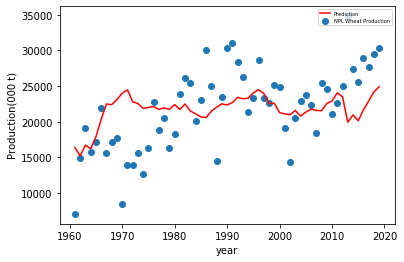

In [298]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0],label="NPL Wheat Production")
plt.plot(xCopy[:,1], yHat, color='r',label="Prediction")
plt.xlabel('year')
plt.ylabel('Production(000 t)')
plt.legend(loc=1, fontsize=5)
plt.show()

In [299]:
abX, abY = dataMat, labelMat
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, abX, abY, scoring='neg_mean_squared_error')

mean_MSE = np.mean(MSEs)

print(mean_MSE)

-146803780.7062788


/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [300]:
from sklearn.metrics import mean_squared_error
print("MSE = ", mean_squared_error(abY, yHat))
print("RMSE = ", np.sqrt(mean_squared_error(abY, yHat)))

MSE =  30155462.432886325
RMSE =  5491.398950439344


## Ridge Regression

In [301]:
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + eye(shape(xMat)[1])*lam
    if linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws

In [302]:
ridgeRegres(mat(abX),mat(abY).T, lam=0.1)

matrix([[ -391.59925733],
        [   13.38475221],
        [ 1508.18856446],
        [  653.82137328],
        [ 7367.83093148],
        [ 2064.42929442],
        [12866.18514019],
        [-8031.92187452],
        [-1684.30363055]])

In [303]:
 def ridgeTest(xArr,yArr):
    xMat = mat(xArr); yMat=mat(yArr).T
    yMean = mean(yMat,0)
    #standartization
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    #regularize X's
    xMeans = mean(xMat,0)   #calc mean then subtract it off
    xStd = std(xMat,0)      #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xStd
    
    
    numTestPts = 30
    wMat = zeros((numTestPts,shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,exp(i-10))
        wMat[i,:]=ws.T
    return wMat

In [304]:
ridgeWeights=ridgeTest(abX,abY)

In [305]:
ridgeWeights[20:25]

array([[  9.86570806,   9.86570806,  -9.22072927,  -4.82464688,
          8.57822594,  -7.56954897,   3.65503275, -10.58907352,
          5.65080149],
       [  3.66355083,   3.66355083,  -3.42102297,  -1.79306235,
          3.18309575,  -2.81253242,   1.35629662,  -3.92975208,
          2.1021861 ],
       [  1.35242693,   1.35242693,  -1.26248538,  -0.66212177,
          1.17474331,  -1.03849057,   0.50055521,  -1.45036915,
          0.77655545],
       [  0.49816666,   0.49816666,  -0.46498102,  -0.24391969,
          0.43267352,  -0.38255845,   0.18436174,  -0.53419926,
          0.28611454],
       [  0.18335158,   0.18335158,  -0.17112997,  -0.08977896,
          0.15924078,  -0.14080577,   0.06785242,  -0.19660745,
          0.10531473]])

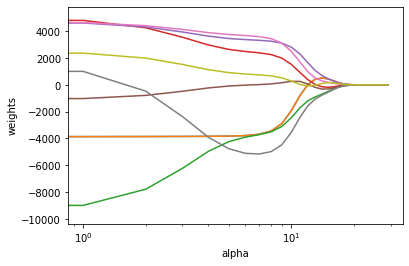

In [306]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
ax.plot(ridgeWeights)
plt.show()

In [307]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.1,  fit_intercept=False).fit(abX,abY) #alpha in sklearn = lambda in our implementation

In [308]:
clf.coef_

array([ -391.59925733,    13.38475221,  1508.18856446,   653.82137328,
        7367.83093148,  2064.42929443, 12866.18514019, -8031.92187452,
       -1684.30363055])

In [309]:
ridgeRegres(mat(abX),mat(abY).T, lam=0.1).T

matrix([[ -391.59925733,    13.38475221,  1508.18856446,   653.82137328,
          7367.83093148,  2064.42929442, 12866.18514019, -8031.92187452,
         -1684.30363055]])

In [310]:
clf.score(abX, abY)

0.58077372210028

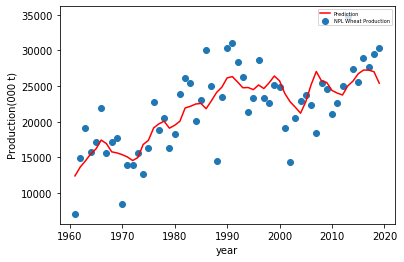

In [311]:
yHat_ridgeRegres = xMat*ridgeRegres(mat(abX),mat(abY).T, lam=0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0],label="NPL Wheat Production")
plt.plot(xCopy[:,1], yHat_ridgeRegres, color='r',label="Prediction")
plt.xlabel('year')
plt.ylabel('Production(000 t)')
plt.legend(loc=1, fontsize=5)
plt.show()

In [312]:
print("MSE = ", mean_squared_error(abY, yHat_ridgeRegres))
print("RMSE = ", np.sqrt(mean_squared_error(abY, yHat_ridgeRegres)))

MSE =  13694356.45190883
RMSE =  3700.5886628898425


In [313]:
clf.get_params(deep=True)

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

## Lasso Regression

In [314]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1, fit_intercept=False).fit(abX,abY)
print(clf.coef_)

[-4.65603518e+02  1.40969200e+01 -4.63343279e+04  9.37486662e+03
  1.82382928e+04 -3.77439466e+03  2.51172156e+04 -8.68004626e+02
  6.37908358e+03]


/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399080006.6556762, tolerance: 2990359.6787800007
  positive)


In [315]:
def lassoTest(xArr,yArr):
    xMat = mat(xArr); yMat=mat(yArr).T
    yMean = mean(yMat,0)
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    #regularize X's
    xMeans = mean(xMat,0)   #calc mean then subtract it off
    xStd = std(xMat,0)      #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xStd
    
    
    numTestPts = 30
    wMat = zeros((numTestPts,shape(xMat)[1]))
    for i in range(numTestPts):
        clf = linear_model.Lasso(alpha=exp(i-10)).fit(xMat,yMat) 
        wMat[i,:]= clf.coef_
    return wMat

In [316]:
lassoWeights=lassoTest(abX,abY)

/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398844791.56296116, tolerance: 192728.14545654238
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397661739.7344737, tolerance: 192728.14545654238
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394458665.33852994, tolerance: 192728.14545654238
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converg

In [317]:
lassoWeights[0:20]

array([[-7.70874395e+03, -0.00000000e+00, -7.43458896e+03,
         4.10416896e+03,  4.24040889e+03, -7.14556025e+02,
         4.35858640e+03, -8.97754534e+02,  1.89338183e+03],
       [-7.70873635e+03, -0.00000000e+00, -7.43452250e+03,
         4.10413829e+03,  4.24039274e+03, -7.14542669e+02,
         4.35857262e+03, -8.97829280e+02,  1.89336122e+03],
       [-7.70871570e+03, -9.90837179e-13, -7.43434184e+03,
         4.10405493e+03,  4.24034886e+03, -7.14506364e+02,
         4.35853517e+03, -8.98032459e+02,  1.89330521e+03],
       [-7.70865956e+03, -7.86320162e-14, -7.43385074e+03,
         4.10382832e+03,  4.24022957e+03, -7.14407676e+02,
         4.35843335e+03, -8.98584760e+02,  1.89315296e+03],
       [-7.70850695e+03, -0.00000000e+00, -7.43251582e+03,
         4.10321235e+03,  4.23990529e+03, -7.14139413e+02,
         4.35815660e+03, -9.00086067e+02,  1.89273909e+03],
       [-7.70809212e+03, -0.00000000e+00, -7.42888710e+03,
         4.10153796e+03,  4.23902383e+03, -7.134101

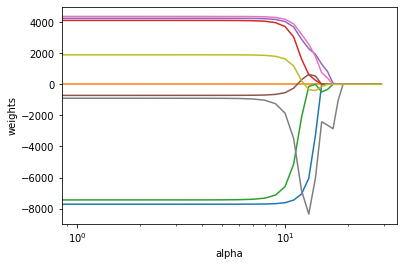

In [318]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.plot(lassoWeights)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

## Use CV for choosing Lambdas in Lasso

In [319]:
def rssError(yArr,yHatArr): #yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

In [320]:
def crossValidation(xArr,yArr,numVal=10):
    m = len(yArr)                           
    indexList = range(m)
    errorMat = zeros((numVal,30))  #create error mat 30columns numVal rows
    for i in range(numVal):
        trainX=[]; trainY=[]
        testX = []; testY = []
        
        indexList = list(range(len(indexList)))
        random.shuffle(indexList)
        for j in range(m):#create training set based on first 90% of values in indexList
            if j < m*0.9: 
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        wMat = lassoTest(trainX,trainY)    #get 30 weight vectors from ridge
        
        for k in range(30):#loop over all of the ridge estimates
            matTestX = mat(testX); matTrainX=mat(trainX)
            meanTrain = mean(matTrainX,0)
            stdTrain = std(matTrainX,0)
            matTestX = (matTestX-meanTrain)/stdTrain #regularize test with training params
            yEst = matTestX * mat(wMat[k,:]).T + mean(trainY)#test ridge results and store
            errorMat[i,k]=rssError(yEst.T.A,array(testY))
            
    meanErrors = mean(errorMat,0)#calc avg performance of the different ridge weight vectors
    minMean = float(min(meanErrors))
    bestWeights = wMat[nonzero(meanErrors==minMean)]
    #can unregularize to get model
    #when we regularized we wrote Xreg = (x-meanX)/var(x)
    #we can now write in terms of x not Xreg:  x*w/var(x) - meanX/var(x) +meanY
    xMat = mat(xArr); yMat=mat(yArr).T
    meanX = mean(xMat,0); stdX = std(xMat,0)
    unReg = bestWeights/stdX
    print("the best model from Lasso is:\n",unReg)
    return unReg, stdX, bestWeights

In [321]:
crossValidation(abX,abY,10)

/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351370710.78343403, tolerance: 156389.95870259262
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351297778.99566495, tolerance: 156389.95870259262
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351099584.3477782, tolerance: 156389.95870259262
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converg

the best model from Lasso is:
 [[   -0.            -0.          -893.16808968     0.
   4935.36314742   961.84485809  4844.89655981 -2535.88352087
  -1876.20889724]]


/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380626989.6121329, tolerance: 160900.80087770373
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380511053.9423811, tolerance: 160900.80087770373
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380195961.2763971, tolerance: 160900.80087770373
  positive)
/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge.

(matrix([[   -0.        ,    -0.        ,  -893.16808968,     0.        ,
           4935.36314742,   961.84485809,  4844.89655981, -2535.88352087,
          -1876.20889724]]),
 matrix([[17.02938637, 17.02938637,  0.15817595,  0.43247007,  0.23106624,
           0.18381893,  0.17256456,  1.16304264,  0.29155637]]),
 array([[   -0.        ,    -0.        ,  -141.27771248,     0.        ,
          1140.39579827,   176.80529515,   836.05742262, -2949.34067525,
          -547.02065096]]))

## In sci-kit learn

In [322]:
from sklearn.linear_model import RidgeCV, LassoCV
ridgeLM = RidgeCV(alphas=[exp(i-10) for i in range(30)], cv=10, 
                  fit_intercept=False).fit(abX, abY)

/Users/chrisxiej/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [323]:
ridgeLM

RidgeCV(alphas=array([4.53999298e-05, 1.23409804e-04, 3.35462628e-04, 9.11881966e-04,
       2.47875218e-03, 6.73794700e-03, 1.83156389e-02, 4.97870684e-02,
       1.35335283e-01, 3.67879441e-01, 1.00000000e+00, 2.71828183e+00,
       7.38905610e+00, 2.00855369e+01, 5.45981500e+01, 1.48413159e+02,
       4.03428793e+02, 1.09663316e+03, 2.98095799e+03, 8.10308393e+03,
       2.20264658e+04, 5.98741417e+04, 1.62754791e+05, 4.42413392e+05,
       1.20260428e+06, 3.26901737e+06, 8.88611052e+06, 2.41549528e+07,
       6.56599691e+07, 1.78482301e+08]),
        cv=10, fit_intercept=False, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [324]:
ridgeLM.coef_

array([ 177.01249169,    8.17120665,  -77.0314765 , -176.55425425,
        188.08462149,   -8.55509529,  -11.97632727, -455.09260686,
        -16.49135864])

In [325]:
ridgeLM.score(abX, abY)

0.44435887673408514

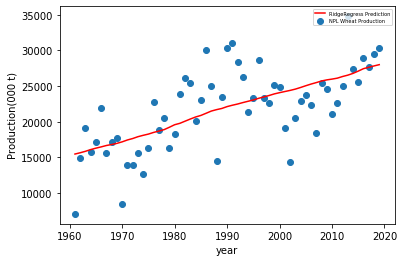

In [326]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0],label="NPL Wheat Production")
plt.plot(xCopy[:,1], ridgeLM.predict(abX), color='r',label="RidgeRegress Prediction")
plt.xlabel('year')
plt.ylabel('Production(000 t)')
plt.legend(loc=1, fontsize=5)
plt.show()

In [327]:
print('MSE =',mean_squared_error(abY, ridgeLM.predict(abX)))

MSE = 18150454.78414065


In [328]:
#CV=10
lassoLM = LassoCV(alphas=[exp(i-10) for i in range(60)], cv=10, 
                  fit_intercept=False, max_iter=1000000).fit(abX, abY)

In [329]:
lassoLM.coef_

array([  -14.45182643,     9.85790556,    -0.        ,  -125.83376186,
           0.        ,    -0.        ,     0.        , -3384.54757536,
          -0.        ])

In [330]:
lassoLM.score(abX, abY)

0.4931041923478293

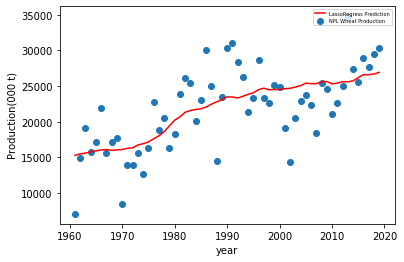

In [215]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0],label="NPL Wheat Production")
plt.plot(xCopy[:,1], lassoLM.predict(abX), color='r',label="LassoRegress Prediction")
plt.legend(loc=1, fontsize=5)
plt.xlabel('year')
plt.ylabel('Production(000 t)')
plt.show()

In [205]:
print('MSE =',mean_squared_error(abY, lassoLM.predict(abX)))
print("RMSE = ", np.sqrt(mean_squared_error(abY, lassoLM.predict(abX))))

MSE = 16558150.669237135
RMSE =  4069.170759409973


In [206]:
lassoLM.get_params(deep=True)

{'alphas': [4.5399929762484854e-05,
  0.00012340980408667956,
  0.00033546262790251185,
  0.0009118819655545162,
  0.0024787521766663585,
  0.006737946999085467,
  0.01831563888873418,
  0.049787068367863944,
  0.1353352832366127,
  0.36787944117144233,
  1.0,
  2.718281828459045,
  7.38905609893065,
  20.085536923187668,
  54.598150033144236,
  148.4131591025766,
  403.4287934927351,
  1096.6331584284585,
  2980.9579870417283,
  8103.083927575384,
  22026.465794806718,
  59874.14171519782,
  162754.79141900392,
  442413.3920089205,
  1202604.2841647768,
  3269017.3724721107,
  8886110.520507872,
  24154952.7535753,
  65659969.13733051,
  178482300.96318725,
  485165195.4097903,
  1318815734.4832146,
  3584912846.131592,
  9744803446.248903,
  26489122129.84347,
  72004899337.38588,
  195729609428.83878,
  532048240601.79865,
  1446257064291.475,
  3931334297144.042,
  10686474581524.463,
  29048849665247.426,
  78962960182680.69,
  214643579785916.06,
  583461742527454.9,
  1586013452

In [207]:
lassoLM.predict(abX)

array([15287.95349164, 15490.09940486, 15598.61671425, 15779.76426748,
       15914.09593288, 16040.04948416, 16102.00384197, 15992.97741422,
       16051.35567879, 16107.5966725 , 16270.83006164, 16339.29663381,
       16746.36603831, 16925.17422925, 17149.96704778, 17603.76274164,
       18030.99607406, 18594.59827602, 19427.12633455, 20208.81372796,
       20675.97450129, 21325.32097427, 21573.52585051, 21716.87877401,
       21810.26996563, 22065.76429983, 22459.38219822, 22785.02825856,
       23078.83201436, 23486.96846837, 23465.25289002, 23325.51919906,
       23565.50929897, 23841.75351659, 24051.00840298, 24489.65637242,
       24703.84291965, 24475.22862909, 24528.01999768, 24492.89295472,
       24631.47755518, 24688.43543219, 24859.18009341, 25051.1391812 ,
       25405.52045565, 25340.62990269, 25329.31721635, 25615.17945087,
       25637.26801593, 25310.22756035, 25407.38742118, 25612.05318146,
       25588.04145413, 25724.48432405, 26183.74996124, 26592.677634  ,
      

In [216]:
#CV=10 training
lassoLM = LassoCV(alphas=[exp(i-10) for i in range(60)], cv=10, 
                  fit_intercept=False, max_iter=1000000).fit(X_train, y_train)

In [217]:
lassoLM.coef_

array([ 0.,  0., -0.,  0., -0.,  0., -0.])

In [218]:
lassoLM.score(X_train, y_train)

-13.727760063570978

In [219]:
#CV=10 testing
lassoLM = LassoCV(alphas=[exp(i-10) for i in range(60)], cv=10, 
                  fit_intercept=False, max_iter=1000000).fit(X_test, y_test)

In [220]:
lassoLM.coef_

array([    -0.        ,      0.        ,     -0.        ,     -0.        ,
         1439.49724664, -20752.93014679,   2244.92354499])

In [221]:
lassoLM.score(X_test, y_test)

0.46767469259783656